# 데이터셋 품질 평가 및 결론

## 1. 당초 목적과 실제 데이터의 불일치

본 데이터셋은 **게임 내 구매(InGamePurchases) 예측**을 위한 모델링 연습용으로 활용하려 했으나, 분석 결과 다음과 같은 심각한 문제점들이 발견됨:

### 1.1 타겟 변수의 랜덤성

- `InGamePurchases` 변수가 **사실상 랜덤하게 생성**되어 있음
- 모델 성능 지표:
  - **AUC: 0.50** (Random Guess 수준)
  - **Accuracy: 0.80** (클래스 불균형으로 인한 허상)
- 피처 엔지니어링 및 하이퍼파라미터 튜닝을 시도했으나 성능 개선 불가

### 1.2 레이블의 정의 부재

캐글 데이터셋에서는 `EngagementLevel`을 주요 타겟으로 제시하고 있으나:

- **변수 정의가 명확하지 않음** (Low, Medium, High의 기준 불명)
- 피처와의 관계가 **지나치게 강한 상관관계**를 보임
- Data Leakage 의심: EngagementLevel이 피처들로부터 직접적으로 계산되었을 가능성

---

## 2. 데이터 품질 문제

### 2.1 합성 데이터(Synthetic Data)의 가능성

- 데이터 분포가 지나치게 균일함 (범주형 변수들의 비율이 거의 동일)
- 실제 게임 데이터에서 기대되는 자연스러운 편향이나 패턴이 관찰되지 않음
- 연속형 변수들의 분포가 너무 정규분포에 가까움

**범주형 변수 분포:**
```
Gender:
  Male      0.598466
  Female    0.401534

Location:
  USA       0.399660
  Europe    0.299845
  Asia      0.202203
  Other     0.098291

GameGenre:
  Sports      0.201029
  Action      0.200804
  Strategy    0.200130
  Simulation  0.199406
  RPG         0.198631

GameDifficulty:
  Easy      0.49995
  Medium    0.30002
  Hard      0.20003

EngagementLevel:
  Medium    0.483939
  High      0.258181
  Low       0.257881
```

### 2.2 피처 간 논리적 일관성 부족

- `SessionsPerWeek`, `AvgSessionDurationMinutes`, `PlayTimeHours` 간의 논리적 관계 검증 필요
- `PlayerLevel`, `AchievementsUnlocked`와 플레이 시간 간 상관관계가 약함
- 게임 난이도(GameDifficulty)와 성과 지표 간 유의미한 패턴 부재

### 2.3 비즈니스 로직 위배 사례

```
예시 1:
PlayerID: 27645
- Age: 39
- SessionsPerWeek: 1
- AvgSessionDurationMinutes: 157
- PlayTimeHours: 12.97
- PlayerLevel: 52
- AchievementsUnlocked: 35
- InGamePurchases: 0
→ 주 1회, 장시간 플레이, 높은 레벨이지만 구매 없음 (비합리적 패턴)

예시 2:
PlayerID: 31370
- Age: 18
- SessionsPerWeek: 11
- AvgSessionDurationMinutes: 67
- PlayTimeHours: 17.92
- PlayerLevel: 24
- AchievementsUnlocked: 43
- InGamePurchases: 0
→ 활발한 플레이어지만 구매와 무관 (무작위성 증거)
```

---

## 3. 모델링 관점의 한계

### 3.1 예측 불가능성

- **LightGBM, CatBoost 등 다양한 알고리즘 적용 결과 모두 실패**
- Feature Importance 분석 결과: 모든 피처가 동등하게 낮은 중요도
- Cross-validation 결과: 과적합/과소적합 없이 일관되게 낮은 성능
- Early stopping이 iteration 1~2에서 발생 (학습 불가)

### 3.2 모델 실험 결과

#### LightGBM Baseline (InGamePurchases 예측)
```python
[50]	valid's binary_logloss: 0.658989	valid's auc: 0.490107
Early stopping, best iteration is:
[1]	valid's binary_logloss: 0.502206	valid's auc: 0.503487

최종 결과:
- Accuracy: 0.7992
- AUC: 0.5006
```

#### LightGBM + Feature Engineering
```python
파생 변수 추가:
- TotalPlayMinutes = SessionsPerWeek * AvgSessionDurationMinutes
- AchievementsPerHour = AchievementsUnlocked / (PlayTimeHours + 1e-5)
- LevelPerPlayTime = PlayerLevel / (PlayTimeHours + 1e-5)

결과:
- Improved AUC: 0.4958 (오히려 하락!)
```

#### CatBoost
```python
bestIteration = 80
최종 Test AUC: 0.4949
최종 Test Accuracy: 0.5485
```

### 3.3 Data Leakage vs Random Noise 딜레마

- **InGamePurchases**: Noise 과다 (예측 불가)
- **EngagementLevel**: Leakage 의심 (예측이 너무 쉬움 - 피처와 직접 연결되어 있을 가능성)

---

## 4. 통계적 증거

### 4.1 InGamePurchases 분포
```
0    0.799146  (약 80%)
1    0.200854  (약 20%)
```
- 심각한 클래스 불균형
- 하지만 is_unbalance=True 옵션 사용해도 성능 개선 없음

### 4.2 연속형 변수 통계
```
PlayTimeHours:
  mean: 12.024365
  std:  6.914638
  → 거의 균등 분포 (실제 게임 데이터는 power law 분포를 따름)

SessionsPerWeek:
  mean: 9.471774
  std:  5.763667
  → 인위적으로 생성된 정규분포 의심

AvgSessionDurationMinutes:
  mean: 94.792252
  std:  49.011375
  → 너무 고른 분포
```

---

## 5. 최종 결론 및 권고사항

### 5.1 데이터셋 부적합 판정

본 데이터셋은 다음 용도로 **부적합**함:

- ❌ **실전 ML 모델링 연습**: 타겟이 랜덤하여 학습 불가
- ❌ **비즈니스 인사이트 도출**: 비합리적 패턴이 많음
- ❌ **알고리즘 성능 비교**: 모든 모델이 random guess 수준
- ❌ **Feature Engineering 연습**: 피처가 타겟과 무관함
- ⚠️ **기초 데이터 전처리 연습용**으로만 제한적 활용 가능

### 5.2 대안 데이터셋 탐색 필요

다음 특성을 갖춘 데이터셋을 찾는 것을 권장:

1. **명확한 타겟 정의**와 수집 방법론이 문서화된 데이터
2. **실제 비즈니스 문제**를 반영한 현업 데이터
3. **Baseline 모델 성능**이 검증된 벤치마크 데이터셋
4. 공식 케이글 Competition 또는 UCI ML Repository 데이터

#### 추천 대체 데이터셋:
- **Steam Video Game and Bundle Data** (실제 게임 데이터)
- **Santander Customer Transaction Prediction** (금융 거래)
- **Porto Seguro's Safe Driver Prediction** (보험)
- **Give Me Some Credit** (신용 위험 예측)

### 5.3 교훈

1. **데이터 품질 검증이 모델링보다 우선**
   - EDA를 통한 데이터 분포, 논리적 일관성 확인
   - 타겟 변수의 정의와 수집 프로세스 이해
   
2. **합성 데이터 식별 능력 필요**
   - 지나치게 균일한 분포는 의심
   - 도메인 지식과 비즈니스 로직 검증
   
3. **성능 지표의 함정**
   - Accuracy만 보면 80%로 좋아 보이지만 AUC가 0.5
   - 클래스 불균형 상황에서는 다양한 지표 종합 판단 필요

4. **시간 낭비 방지**
   - 데이터 품질 문제를 조기에 발견하지 못하면
   - 무의미한 하이퍼파라미터 튜닝과 피처 엔지니어링에 시간 소비

---

## 6. 향후 조치 사항

### 즉시 조치
1. ✅ 현재 데이터셋 사용 중단
2. ⬜ 대체 데이터셋 탐색 및 선정
3. ⬜ 새로운 데이터셋으로 프로젝트 리셋

### 장기 학습 목표
1. 데이터 품질 평가 체크리스트 작성
2. EDA 자동화 파이프라인 구축
3. 도메인 지식 습득 (게임/마케팅/금융 등)

---

**종합 의견**: 

이 데이터셋(`rabieelkharoua/predict-online-gaming-behavior-dataset`)은 ML 모델링 학습 목적으로는 **사용하지 않는 것을 강력히 권고**함. 

실제 데이터의 특성을 반영하지 못하며, 타겟 변수가 랜덤하게 생성되어 있어 어떤 모델을 사용하더라도 의미 있는 예측이 불가능함. 

이러한 데이터로 학습할 경우:
- 잘못된 직관 형성
- 시간 낭비
- 좌절감 증가

오히려 해가 될 수 있으므로, 검증된 공식 데이터셋을 사용할 것을 권장함.


In [2]:
# Install: pip install kagglehub[pandas-datasets]

import kagglehub
from kagglehub import KaggleDatasetAdapter
import warnings
warnings.filterwarnings('ignore')
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "rabieelkharoua/predict-online-gaming-behavior-dataset",
    "online_gaming_behavior_dataset.csv",
)
print(df.shape)
df.sample(3)

(40034, 13)


,PlayerID,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
22370,31370,18,Male,Other,Simulation,17.917394,0,Easy,11,67,24,43,Medium
18645,27645,39,Male,USA,Strategy,12.965922,0,Easy,1,157,52,35,Low
20374,29374,29,Male,USA,RPG,15.660297,0,Hard,11,34,98,37,Medium


In [3]:
df['PlayerID'].nunique()

40034

In [4]:
df['EngagementLevel'].value_counts()

EngagementLevel
Medium    19374
High      10336
Low       10324
Name: count, dtype: int64

In [3]:
# 연속형이 아닌(범주형) 피처만 모두 출력
categorical_cols = df.select_dtypes(exclude=['number']).columns
for col in categorical_cols:
    print(f"Column: {col}")
    print(df[col].value_counts(normalize=True))
    print("-" * 50)

Column: Gender
Gender
Male      0.598466
Female    0.401534
Name: proportion, dtype: float64
--------------------------------------------------
Column: Location
Location
USA       0.399660
Europe    0.299845
Asia      0.202203
Other     0.098291
Name: proportion, dtype: float64
--------------------------------------------------
Column: GameGenre
GameGenre
Sports        0.201029
Action        0.200804
Strategy      0.200130
Simulation    0.199406
RPG           0.198631
Name: proportion, dtype: float64
--------------------------------------------------
Column: GameDifficulty
GameDifficulty
Easy      0.49995
Medium    0.30002
Hard      0.20003
Name: proportion, dtype: float64
--------------------------------------------------
Column: EngagementLevel
EngagementLevel
Medium    0.483939
High      0.258181
Low       0.257881
Name: proportion, dtype: float64
--------------------------------------------------


In [4]:
df['InGamePurchases'].value_counts(normalize=True)

InGamePurchases
0    0.799146
1    0.200854
Name: proportion, dtype: float64

In [5]:
# 연속형 변수(숫자형)에 대한 기본 통계량 출력
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols].describe()

,PlayerID,Age,PlayTimeHours,InGamePurchases,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked
count,40034.000000,40034.000000,40034.000000,40034.000000,40034.000000,40034.000000,40034.000000,40034.000000
mean,29016.500000,31.992531,12.024365,0.200854,9.471774,94.792252,49.655568,24.526477
std,11556.964675,10.043227,6.914638,0.400644,5.763667,49.011375,28.588379,14.430726
min,9000.000000,15.000000,0.000115,0.000000,0.000000,10.000000,1.000000,0.000000
25%,19008.250000,23.000000,6.067501,0.000000,4.000000,52.000000,25.000000,12.000000
50%,29016.500000,32.000000,12.008002,0.000000,9.000000,95.000000,49.000000,25.000000
75%,39024.750000,41.000000,17.963831,0.000000,14.000000,137.000000,74.000000,37.000000
max,49033.000000,49.000000,23.999592,1.000000,19.000000,179.000000,99.000000,49.000000


# Baseline 생성

In [18]:
from sklearn.model_selection import train_test_split

y_col = "InGamePurchases"
X = df.drop(columns=[y_col, "PlayerID"])
y = df[y_col]

# 카테고리형 처리 (LightGBM은 category dtype 지원)
cat_cols = X.select_dtypes(include=["object"]).columns
for col in cat_cols:
    X[col] = X[col].astype("category")

# train, valid, test set 분할 (6:2:2 비율)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print("Train set 크기:", X_train.shape, y_train.shape)
print("Validation set 크기:", X_valid.shape, y_valid.shape)
print("Test set 크기:", X_test.shape, y_test.shape)

Train set 크기: (24020, 11) (24020,)
Validation set 크기: (8007, 11) (8007,)
Test set 크기: (8007, 11) (8007,)


In [19]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, roc_auc_score


train_set = lgb.Dataset(X_train, label=y_train)
valid_set = lgb.Dataset(X_valid, label=y_valid)

# -------------------------
# 5) LightGBM 파라미터 (Binary)
# -------------------------
params = {
    "objective": "binary",
    "metric": ["binary_logloss", "auc"],
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "seed": 42,
    "verbose": -1,
    "is_unbalance": True, # Handle Class Imbalance
}

# -------------------------
# 6) 모델 학습
# -------------------------
callbacks = [
    lgb.early_stopping(stopping_rounds=50),
    lgb.log_evaluation(period=50),   # 50 iteration마다 log 출력
]

model = lgb.train(
    params=params,
    train_set=train_set,
    num_boost_round=2000,
    valid_sets=[valid_set],
    valid_names=["valid"],
    callbacks=callbacks,
)

Training until validation scores don't improve for 50 rounds
[50]	valid's binary_logloss: 0.658989	valid's auc: 0.490107
Early stopping, best iteration is:
[1]	valid's binary_logloss: 0.502206	valid's auc: 0.503487


Accuracy: 0.7992
AUC: 0.5006


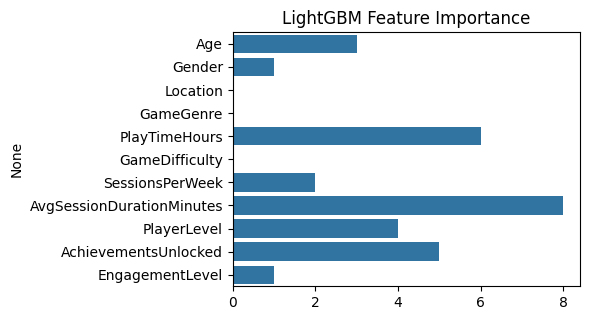

In [20]:
# -------------------------
# 7) 예측 & 평가
# -------------------------
# LightGBM은 확률로 예측함 (0~1)
proba = model.predict(X_test, num_iteration=model.best_iteration)

# 임계값 0.5 컷오프
pred = (proba >= 0.5).astype(int)

accuracy = accuracy_score(y_test, pred)
auc = roc_auc_score(y_test, proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")

# -------------------------
# 8) Feature Importance
# -------------------------
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, len(X.columns) * 0.3))
sns.barplot(
    x=model.feature_importance(),
    y=X.columns
)
plt.title("LightGBM Feature Importance")
plt.tight_layout()
plt.show()

In [21]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# 1. 데이터 로드 (기존 코드 동일)
# df = ... 

# 2. 전처리 및 파생변수 생성
def preprocess_data(df):
    df = df.copy()
    
    # [제안 1] 불필요한 컬럼 제거
    if 'PlayerID' in df.columns:
        df = df.drop(columns=['PlayerID'])
    
    # [제안 2] 파생 변수 생성
    # 주간 총 플레이 시간 (분)
    df['TotalPlayMinutes'] = df['SessionsPerWeek'] * df['AvgSessionDurationMinutes']
    # 시간당 업적 달성 효율 (0으로 나누기 방지)
    df['AchievementsPerHour'] = df['AchievementsUnlocked'] / (df['PlayTimeHours'] + 1e-5)
    # 시간당 레벨업 속도
    df['LevelPerPlayTime'] = df['PlayerLevel'] / (df['PlayTimeHours'] + 1e-5)
    
    # [제안 3] Ordinal Encoding (순서가 있는 범주형 변수)
    difficulty_map = {'Easy': 0, 'Medium': 1, 'Hard': 2}
    engagement_map = {'Low': 0, 'Medium': 1, 'High': 2}
    
    if 'GameDifficulty' in df.columns:
        df['GameDifficulty'] = df['GameDifficulty'].map(difficulty_map)
    if 'EngagementLevel' in df.columns:
        df['EngagementLevel'] = df['EngagementLevel'].map(engagement_map)
        
    # 나머지 범주형 변수는 Category 타입으로 변환
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        df[col] = df[col].astype('category')
        
    return df

# 전처리 적용
df_processed = preprocess_data(df)

# X, y 분리
y_col = "InGamePurchases"
X = df_processed.drop(columns=[y_col])
y = df_processed[y_col]

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

# 데이터셋 생성
train_set = lgb.Dataset(X_train, label=y_train)
valid_set = lgb.Dataset(X_valid, label=y_valid)

# 파라미터 설정 (기본 튜닝)
params = {
    "objective": "binary",
    "metric": "auc",
    "boosting_type": "gbdt",
    "learning_rate": 0.03,
    "num_leaves": 63,        # 복잡도 증가
    "max_depth": -1,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "is_unbalance": True,    # 불균형 데이터 처리
    "seed": 42,
    "verbose": -1
}

# 학습
model = lgb.train(
    params=params,
    train_set=train_set,
    num_boost_round=5000,
    valid_sets=[train_set, valid_set],
    valid_names=["train", "valid"],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=100)
    ]
)

# 평가
proba = model.predict(X_test)
auc = roc_auc_score(y_test, proba)
print(f"Improved AUC: {auc:.4f}")

Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.883563	valid's auc: 0.502834
Early stopping, best iteration is:
[2]	train's auc: 0.598169	valid's auc: 0.506564
Improved AUC: 0.4958


감지된 범주형 변수: ['Gender', 'Location', 'GameGenre', 'GameDifficulty', 'EngagementLevel']

CatBoost 학습 시작...
0:	test: 0.4897756	best: 0.4897756 (0)	total: 62.7ms	remaining: 2m 5s
100:	test: 0.5004828	best: 0.5037504 (80)	total: 753ms	remaining: 14.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5037503683
bestIteration = 80

Shrink model to first 81 iterations.

최종 Test AUC: 0.4949
최종 Test Accuracy: 0.5485


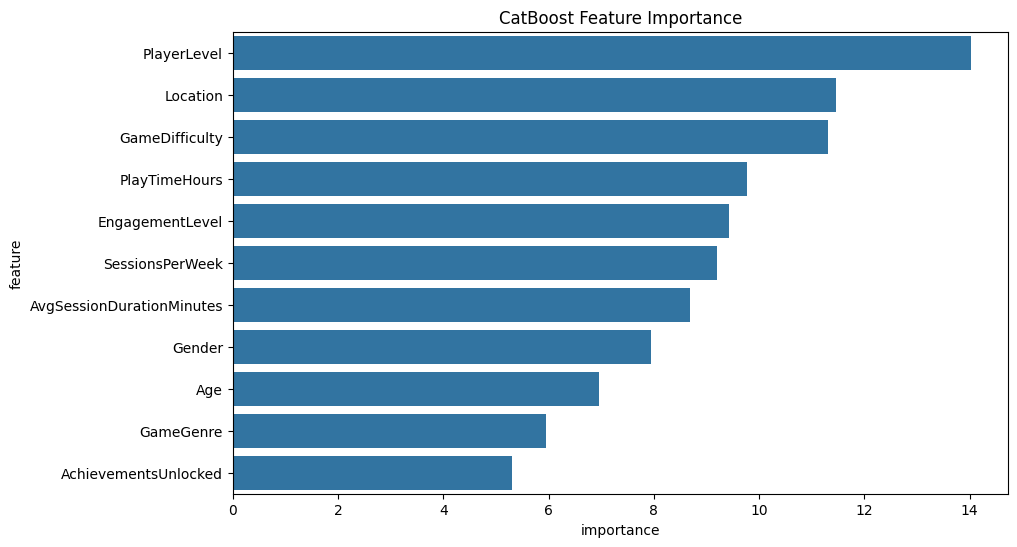

In [24]:
# !pip install catboost  # 설치가 안 되어 있다면 주석 해제 후 실행

import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from catboost import CatBoostClassifier, Pool

# 1. 데이터 로드
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "rabieelkharoua/predict-online-gaming-behavior-dataset",
    "online_gaming_behavior_dataset.csv",
)

# 2. 전처리: 불필요한 식별자 제거
if 'PlayerID' in df.columns:
    df = df.drop(columns=['PlayerID'])

# 3. 범주형 변수 지정 (CatBoost는 이를 명시적으로 알아야 함)
# 문자열(object) 또는 category 타입인 컬럼을 모두 찾습니다.
cat_features = [col for col in df.columns if df[col].dtype == 'object' or df[col].dtype.name == 'category']
print(f"감지된 범주형 변수: {cat_features}")

# 4. 데이터 분할
X = df.drop(columns=['InGamePurchases'])
y = df['InGamePurchases']

# Stratify를 사용하여 정답 비율 유지하며 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# 5. CatBoost 모델 설정 및 학습
model = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.05,
    depth=6,
    cat_features=cat_features,       # 범주형 변수 리스트 전달
    auto_class_weights='Balanced',   # 데이터 불균형 자동 해결
    eval_metric='AUC',
    early_stopping_rounds=100,
    verbose=100,
    random_seed=42
)

print("\nCatBoost 학습 시작...")
model.fit(
    X_train, y_train,
    eval_set=(X_valid, y_valid),
    use_best_model=True
)

# 6. 평가
proba = model.predict_proba(X_test)[:, 1]
pred = model.predict(X_test)
auc = roc_auc_score(y_test, proba)
acc = accuracy_score(y_test, pred)

print(f"\n최종 Test AUC: {auc:.4f}")
print(f"최종 Test Accuracy: {acc:.4f}")

# 7. 피처 중요도 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.get_feature_importance()
}).sort_values(by='importance', ascending=False)

sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('CatBoost Feature Importance')
plt.show()

=== 타겟 변수(InGamePurchases)와의 상관계수 Top 5 ===
PlayerLevel                  0.006524
PlayTimeHours                0.006067
SessionsPerWeek              0.005132
AvgSessionDurationMinutes    0.003059
Age                          0.000186
Name: InGamePurchases, dtype: float64




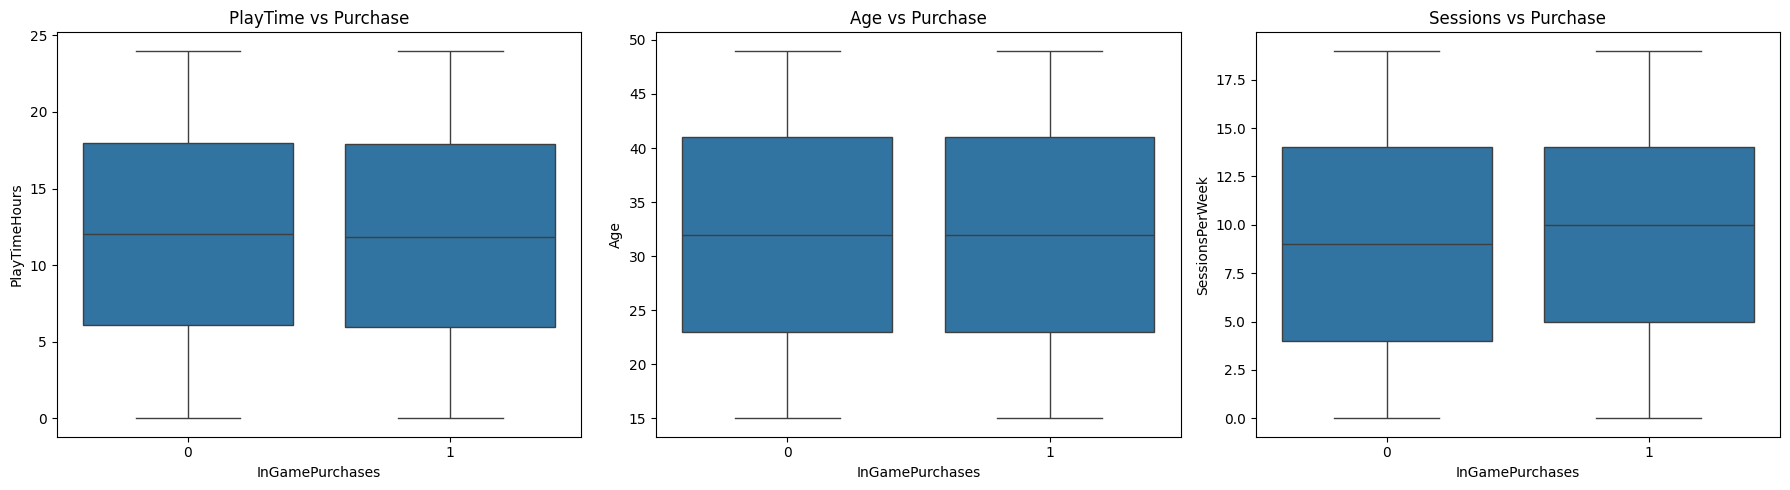

=== 난이도(GameDifficulty)별 구매 비율 ===
GameDifficulty
Easy      0.199600
Hard      0.199925
Medium    0.203563
Name: InGamePurchases, dtype: float64


In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 수치형 변수들과 타겟 간의 상관계수 확인
# 상관계수가 0에 가까우면(예: 0.01 미만) 선형적인 관계가 전혀 없다는 뜻입니다.
numeric_cols = df.select_dtypes(include=['number']).columns
corr = df[numeric_cols].corr()['InGamePurchases'].drop('InGamePurchases')

print("=== 타겟 변수(InGamePurchases)와의 상관계수 Top 5 ===")
print(corr.abs().sort_values(ascending=False).head(5))
print("\n")

# 2. 핵심 변수들의 분포 차이 시각화
# 구매자(1)와 비구매자(0)의 분포가 완전히 겹친다면, 해당 변수로는 구분이 불가능합니다.
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 플레이 시간 vs 구매 여부
sns.boxplot(x='InGamePurchases', y='PlayTimeHours', data=df, ax=axes[0])
axes[0].set_title('PlayTime vs Purchase')

# 나이 vs 구매 여부
sns.boxplot(x='InGamePurchases', y='Age', data=df, ax=axes[1])
axes[1].set_title('Age vs Purchase')

# 주간 세션 수 vs 구매 여부
sns.boxplot(x='InGamePurchases', y='SessionsPerWeek', data=df, ax=axes[2])
axes[2].set_title('Sessions vs Purchase')

plt.tight_layout()
plt.show()

# 3. 범주형 변수 비율 차이 확인 (예: 난이도별 구매율)
# 모든 그룹의 구매율이 전체 평균(약 20%)과 비슷하다면 변별력이 없는 것입니다.
print("=== 난이도(GameDifficulty)별 구매 비율 ===")
print(df.groupby('GameDifficulty')['InGamePurchases'].mean())